In [1]:
#Module Dependencies
import time
import urllib
import re
import requests
import pandas as pd
import numpy as np

#HTTP REST Modules
from http.client import HTTPSConnection
from base64 import b64encode
from json import loads
from json import dumps

# Urlparse for URL Parsing ;) 
from urllib.parse import urlparse

import json
from collections import defaultdict
import pickle

# Data visualisation packages
import seaborn as sns
from matplotlib import pyplot as plt

# Obtaining All Of The GMB Categories

<img src='gmb_categories.png' /> 

So the first stage of our scraping operation involves collecting ~2180 Google My Business categories and transforming them into a list. Thankfully, we can find a pre-made <a href='https://www.solidstratagems.com/google-my-business-categories/'>list of the GMB categories from this article.</a> 

We will then use the GMB categories as <strong> keywords, then take the UK national search volume for these keywords as a proxy for demand </strong> on a local level. Despite this not being completely accurate it will allow us to focus our search on profitable niches, here's the process:

- Extract all of the GMB categories and enter the keywords into an Ahrefs keyword search.
- Sort the list by monthly search volume and select the top 300 keywords for closer inspection.

------------------------------------------------------------------------------------------------------------------------

# Data Cleaning For Profitable Niche + Location Keywords

<img src='300_search_volume_keywords_cleaned.png' /> 

After extracting the lists, then I manually reviewed every keyword and removed any non-profitable GMB categories or companies that would not take kindly to a pitch. These included GMB's such as park's, churches or local monuments. 

- Businesses with a low relevance or low CPC were removed.

Now we're simply left with a <strong> list of niche keywords </strong> that we can use to <strong> find prospective local seo clients with Python and automation. </strong>

- Businesses with a low relevance and small avg.CPC were removed.

In [ ]:
df = pd.read_csv('keywords.csv')
df.head(15)

<img src='keyword_list.png' />

We can extract the list of queries that will be utilised to query a specific geo-location of Google via a cheap SERP API.

In [7]:
query_list = list(df['Keyword'])

In [8]:
len(query_list)

201

In [9]:
query_list[15:30]

['bank',
 'dentist',
 'bar',
 'passport office',
 'store',
 'cafe',
 'college',
 'karaoke',
 'spa',
 'university',
 'hospital',
 'casino',
 'osteopath',
 'council',
 'podiatrist']

------------------------------------------------------------------------------------------------------------------------------------

# Creating A REST Client For DataForSEO.com

The code below just allows us to create a RestClient for accessing dataforseo's API. Its actually a very simple process and they provide extensive documentation on their website.

In [ ]:
class RestClient:
    domain = "api.dataforseo.com"

    def __init__(self, username, password):
        self.username = username
        self.password = password

    def request(self, path, method, data=None):
        connection = HTTPSConnection(self.domain)
        try:
            base64_bytes = b64encode(
                ("%s:%s" % (self.username, self.password)).encode("ascii")
                ).decode("ascii")
            headers = {'Authorization' : 'Basic %s' %  base64_bytes}
            connection.request(method, path, headers=headers, body=data)
            response = connection.getresponse()
            return loads(response.read().decode())
        finally:
            connection.close()

    def get(self, path):
        return self.request(path, 'GET')

    def post(self, path, data):
        if isinstance(data, str):
            data_str = data
        else:
            data_str = dumps(data)
        return self.request(path, 'POST', data_str)

In [ ]:
username = input()
password = input()

In [ ]:
client = RestClient(username, password)

## Finding The Right Geo-Code For Our Local Business Prospecting

Now we can need to query the SERP API with each of the niche keywords, luckily I will be utilising <a href='https://dataforseo.com/' > DataForSEO.com </a>. But firstly as we're looking to prospect for local SEO businesses <strong> we need to apply a geo-specific Google API search. </strong> DataforSEO has native support for this and will allow us to pass the right geo-parameters to make our Google search specific to Reading.

In [190]:
response = client.get("/v2/cmn_locations")
if response["status"] == "error":
    print("error. Code: %d Message: %s" % (response["error"]["code"], response["error"]["message"]))
else:
    locations = response["results"]

In [193]:
pd.DataFrame(locations).to_csv('locations.csv')

In [6]:
location_data = pd.read_csv("locations.csv")

In [7]:
location_data.head(5)

,Unnamed: 0,loc_id,loc_id_parent,loc_name,loc_name_canonical,loc_type,loc_country_iso_code,dma_region,kwrd_finder,kwrd_finder_lang
0,0,2020,NaN,Andorra,Andorra,Country,AD,False,False,NaN
1,1,9075384,2020.0,Andorra la Vella,"Andorra la Vella,Andorra",Region,AD,False,False,NaN
2,2,9075379,2020.0,Canillo,"Canillo,Andorra",Region,AD,False,False,NaN
3,3,9075380,2020.0,Encamp,"Encamp,Andorra",Region,AD,False,False,NaN
4,4,9075383,2020.0,Escaldes-Engordany,"Escaldes-Engordany,Andorra",Region,AD,False,False,NaN


As we will only be prospecting the Reading location, we can filter out list of 90,000 geo-codes to specifically target this geo-area.

In [12]:
reading_location = location_data[(location_data['loc_name_canonical'].str.contains("United Kingdom")) 
                                 & location_data['loc_name'].str.contains("RG4") ]

In [13]:
reading_location

,Unnamed: 0,loc_id,loc_id_parent,loc_name,loc_name_canonical,loc_type,loc_country_iso_code,dma_region,kwrd_finder,kwrd_finder_lang
23434,23434,9046105,20339.0,RG40,"RG40,England,United Kingdom",Postal Code,GB,False,False,NaN
23435,23435,9046106,20339.0,RG41,"RG41,England,United Kingdom",Postal Code,GB,False,False,NaN
23436,23436,9046101,20339.0,RG42,"RG42,England,United Kingdom",Postal Code,GB,False,False,NaN
23437,23437,9046104,20339.0,RG45,"RG45,England,United Kingdom",Postal Code,GB,False,False,NaN
23438,23438,9046112,20339.0,RG4,"RG4,England,United Kingdom",Postal Code,GB,False,False,NaN


------------------------------------------------------------------------------------------------------------------------

The code below just allows us to create a RestClient for accessing dataforseo's API. Its actually a very simple process and they provide extensive documentation on their website.

test
password


# 1 Query To Test The API

Before making a large number of requests and spending lots of credits, I decided to test the API with just one keyword "party wigs".

In [36]:
post_data = dict()
post_data[30000000] = dict(
    priority=1,
    se_name="google.co.uk",
    se_language="English",
    loc_name_canonical="London,England,United Kingdom",
    key="party wigs")

In [37]:
post_data

{30000000: {'priority': 1,
  'se_name': 'google.co.uk',
  'se_language': 'English',
  'loc_name_canonical': 'London,England,United Kingdom',
  'key': 'party wigs'}}

In [39]:
response = client.post("/v2/srp_tasks_post", dict(data=post_data))
if response["status"] == "error":
    print("error. Code: %d Message: %s" % (response["error"]["code"], response["error"]["message"]))
else:
    print(response["results"])

{'30000000': {'status': 'ok', 'post_id': 30000000, 'post_key': 'party wigs', 'task_id': 12026760761, 'se_id': 22, 'loc_id': 1006886, 'key_id': 1562667}}


# Let's Retrieve Our One Task

In [88]:
response = client.get("/v2/srp_tasks_get")
if response["status"] == "error":
    print("error. Code: %d Message: %s" % (response["error"]["code"], response["error"]["message"]))
else:
    print(response["results"])

[]


# Querying The SERP API For 201 Queries

This part is setting up the query for all of the 201 SERP keyword queries. It will return back 201 SERP results with the top 100 domains for every keyword.

In [93]:
data = defaultdict(dict)

priority = 1
se_name = "google.co.uk"
se_language = "English"
loc_name_canonical = "RG4,England,United Kingdom"

for i, keys in zip(range(1,len(query_list)), query_list):
    
    # Creating the nested dictionary
    data[i] = {}

    data[i]['priority'] = priority
    data[i]['se_name'] = se_name
    data[i]['se_language'] = se_language
    data[i]['loc_name_canonical'] = loc_name_canonical
    
    # Dynamically Adding The Queries
    data[i]['key'] = keys

In [95]:
# Posting For Data

In [96]:
response = client.post("/v2/srp_tasks_post", dict(data=data))
if response["status"] == "error":
    print("error. Code: %d Message: %s" % (response["error"]["code"], response["error"]["message"]))
else:
    print(response["results"])

{'1': {'status': 'ok', 'post_id': 1, 'post_key': 'post office', 'task_id': 12027141257, 'se_id': 22, 'loc_id': 9046112, 'key_id': 68127}, '2': {'status': 'ok', 'post_id': 2, 'post_key': 'entertainer', 'task_id': 12027141277, 'se_id': 22, 'loc_id': 9046112, 'key_id': 4072523}, '3': {'status': 'ok', 'post_id': 3, 'post_key': 'science museum', 'task_id': 12027141298, 'se_id': 22, 'loc_id': 9046112, 'key_id': 1310993}, '4': {'status': 'ok', 'post_id': 4, 'post_key': 'library', 'task_id': 12027141317, 'se_id': 22, 'loc_id': 9046112, 'key_id': 1212738}, '5': {'status': 'ok', 'post_id': 5, 'post_key': 'hotel', 'task_id': 12027141338, 'se_id': 22, 'loc_id': 9046112, 'key_id': 863865}, '6': {'status': 'ok', 'post_id': 6, 'post_key': 'swimming pool', 'task_id': 12027141355, 'se_id': 22, 'loc_id': 9046112, 'key_id': 731205}, '7': {'status': 'ok', 'post_id': 7, 'post_key': 'chiropractor', 'task_id': 12027141372, 'se_id': 22, 'loc_id': 9046112, 'key_id': 1013214}, '8': {'status': 'ok', 'post_id': 8

# Obtaining Our SERP Data

Now that all of our tasks have been sent to the DataForSEO's API servers we can simply call back all of the tasks and extract all of the results.

In [98]:
final_results = []

completed_tasks_response = client.get("/v2/srp_tasks_get")
if completed_tasks_response["status"] == "error":
    print("error. Code: %d Message: %s" % (completed_tasks_response["error"]["code"], completed_tasks_response["error"]["message"]))
else:
    results = completed_tasks_response["results"]
    print(results)
    for result in results:
        srp_response = client.get("/v2/srp_tasks_get/%d" % (result["task_id"]))
        if srp_response["status"] == "error":
            print("error. Code: %d Message: %s" % (srp_response["error"]["code"], srp_response["error"]["message"]))
        else:
            final_results.append(srp_response["results"])

[{'post_id': '70', 'post_key': 'chimney sweep', 'task_id': 12027031107, 'se_id': 22, 'loc_id': 9046112, 'key_id': 3445065, 'results_count': 12600000, 'result_extra': 'people_also_ask,images,local_pack', 'result_spell': '', 'result_spell_type': '', 'result_se_check_url': 'https://www.google.co.uk/search?q=chimney%20sweep&num=100&hl=en&gl=GB&gws_rd=cr&ie=UTF-8&oe=UTF-8&uule=w+CAIQIFISCcM8HUfhhHZIEbzKx0ulhCYF'}, {'post_id': '1', 'post_key': 'post office', 'task_id': 12027141257, 'se_id': 22, 'loc_id': 9046112, 'key_id': 68127, 'results_count': 8080000000, 'result_extra': 'people_also_ask,images,knowledge_graph,google_review,local_pack', 'result_spell': '', 'result_spell_type': '', 'result_se_check_url': 'https://www.google.co.uk/search?q=post%20office&num=100&hl=en&gl=GB&gws_rd=cr&ie=UTF-8&oe=UTF-8&uule=w+CAIQIFISCcM8HUfhhHZIEbzKx0ulhCYF'}, {'post_id': '2', 'post_key': 'entertainer', 'task_id': 12027141277, 'se_id': 22, 'loc_id': 9046112, 'key_id': 4072523, 'results_count': 91200000, 'res

In [102]:
pickle.dump(final_results, open('SERP_data.pkl', 'wb'))

##  Data Munging The Arrays

In [112]:
for i, j in final_results[0].items():
    print(test)
    for item in j:
        print(item)

related
{'post_id': '70', 'task_id': 12027031107, 'se_id': 22, 'loc_id': 9046112, 'key_id': 3445065, 'post_key': 'chimney sweep', 'result_datetime': '2019-10-28 23:58:11 +00:00', 'result_position': 1, 'result_url': 'https://www.hetas.co.uk/find-chimney-sweep/', 'result_breadcrumb': 'https://www.hetas.co.uk › find-chimney-sweep', 'result_title': 'Chimney Sweep Search | Find a Chimney Sweep Near Me', 'result_snippet_extra': '', 'result_snippet': 'Find you local HETAS Approved Chimney Sweep using the HETAS interactive search. Simply enter your postcode to find your local chimney sweep.', 'results_count': 12600000, 'result_extra': 'people_also_ask,images,local_pack', 'result_stat': [], 'result_spell': '', 'result_spell_type': '', 'result_highlighted': ['Chimney Sweep', 'chimney sweep'], 'result_se_check_url': 'https://www.google.co.uk/search?q=chimney%20sweep&num=100&hl=en&gl=GB&gws_rd=cr&ie=UTF-8&oe=UTF-8&uule=w+CAIQIFISCcM8HUfhhHZIEbzKx0ulhCYF'}
{'post_id': '70', 'task_id': 12027031107, 

# Creating A New Data-Structure.

In [21]:
master_dict = {
    
    'post_key': [],
    'result_position': [],
    'result_url': [],
    'result_title': []
    
}

In [22]:
key_list = ['post_key', 'result_position', 'result_url', 'result_title']

# The Order Is Returned In The Following: Post_Key, Position, URL, Title which matches the order of our master_dict.

In [29]:
i = 0

while i < len(raw_data):
    
    # Query Every Keyword SERP Page.
    for data in raw_data[i]['organic']:
        for keys, values in data.items():
            if keys in key_list:
                master_dict[str(keys)].append(values)
                
    # Iterate I
    i += 1
        
    print("{} x 100 Result SERP Completed".format(i / len(raw_data)))

0.005 x 100 Result SERP Completed
0.01 x 100 Result SERP Completed
0.015 x 100 Result SERP Completed
0.02 x 100 Result SERP Completed
0.025 x 100 Result SERP Completed
0.03 x 100 Result SERP Completed
0.035 x 100 Result SERP Completed
0.04 x 100 Result SERP Completed
0.045 x 100 Result SERP Completed
0.05 x 100 Result SERP Completed
0.055 x 100 Result SERP Completed
0.06 x 100 Result SERP Completed
0.065 x 100 Result SERP Completed
0.07 x 100 Result SERP Completed
0.075 x 100 Result SERP Completed
0.08 x 100 Result SERP Completed
0.085 x 100 Result SERP Completed
0.09 x 100 Result SERP Completed
0.095 x 100 Result SERP Completed
0.1 x 100 Result SERP Completed
0.105 x 100 Result SERP Completed
0.11 x 100 Result SERP Completed
0.115 x 100 Result SERP Completed
0.12 x 100 Result SERP Completed
0.125 x 100 Result SERP Completed
0.13 x 100 Result SERP Completed
0.135 x 100 Result SERP Completed
0.14 x 100 Result SERP Completed
0.145 x 100 Result SERP Completed
0.15 x 100 Result SERP Comple

# The SERP Data After Data Extraction

After extracting all <strong> 201 keyword queries within the geo-code of Reading. </strong> we can inspect the data, also we will be stripping out the root domain element of every URL. This will serve as a brand-able query that we can use to search for knowledge panels via a different python script.

In [32]:
df = pd.DataFrame(master_dict)

In [34]:
df.head(15)

,post_key,result_position,result_url,result_title
0,chimney sweep,1,https://www.hetas.co.uk/find-chimney-sweep/,Chimney Sweep Search | Find a Chimney Sweep Ne...
1,chimney sweep,2,https://www.readingsweep.co.uk/,"VIRGO Chimney Sweep in Reading, Berkshire"
2,chimney sweep,3,https://www.checkatrade.com/Search/Chimney-Swe...,Chimney Sweep in Reading - Find a trade with C...
3,chimney sweep,4,https://www.acsweep.co.uk/,"Adams Chimney Sweep in Reading, Berkshire"
4,chimney sweep,5,https://www.yell.com/s/chimney+sweeps-reading....,Chimney Sweeps in Reading | Get a Quote - Yell
5,chimney sweep,6,https://www.findachimneysweep.co.uk/,Find a Chimney Sweep near me - UK directory of...
6,chimney sweep,7,https://www.lockchimneysweepsreading.co.uk/,Locks Chimney Sweep | Professional Chimney Swe...
7,chimney sweep,8,https://nacs.org.uk/,Home - The National Association of Chimney Swe...
8,chimney sweep,9,https://en.wikipedia.org/wiki/Chimney_sweep,Chimney sweep - Wikipedia
9,chimney sweep,10,https://www.stovesonline.co.uk/services/chimne...,Find your local chimney sweeps UK


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19793 entries, 0 to 19792
Data columns (total 4 columns):
post_key           19793 non-null object
result_position    19793 non-null int64
result_url         19793 non-null object
result_title       19793 non-null object
dtypes: int64(1), object(3)
memory usage: 618.7+ KB


# Data Cleaning

Now that we've extracted our 200 geo-queries into a dataframe we need to clean the data, obtain the root domains. So let's get to it!

In [64]:
def get_base_domain(x):

    parsed = urlparse(x)
    domain = parsed.netloc.split(".")[1:]
    host = ".".join(domain)

    return host

#### 1. Extract The Root Domain

In [73]:
df['Root_Domain'] = df['result_url'].apply(lambda x: get_base_domain(x))
df.head()

,post_key,result_position,result_url,result_title,Root_Domain
0,chimney sweep,1,https://www.hetas.co.uk/find-chimney-sweep/,Chimney Sweep Search | Find a Chimney Sweep Ne...,hetas.co.uk
1,chimney sweep,2,https://www.readingsweep.co.uk/,"VIRGO Chimney Sweep in Reading, Berkshire",readingsweep.co.uk
2,chimney sweep,3,https://www.checkatrade.com/Search/Chimney-Swe...,Chimney Sweep in Reading - Find a trade with C...,checkatrade.com
3,chimney sweep,4,https://www.acsweep.co.uk/,"Adams Chimney Sweep in Reading, Berkshire",acsweep.co.uk
4,chimney sweep,5,https://www.yell.com/s/chimney+sweeps-reading....,Chimney Sweeps in Reading | Get a Quote - Yell,yell.com


#### 2. De-duplicate against Root Domain

In [83]:
df.drop_duplicates(subset='Root_Domain', inplace = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3187 entries, 0 to 19727
Data columns (total 5 columns):
post_key           3187 non-null object
result_position    3187 non-null int64
result_url         3187 non-null object
result_title       3187 non-null object
Root_Domain        3187 non-null object
dtypes: int64(1), object(4)
memory usage: 149.4+ KB


/Users/jamesphoenix/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


##### 3. Let's remove anything above position 36+, simply to just reduce the size of our dataset.

In [84]:
df = df[df['result_position'] < 36]

#### 4. Removing The Large Directory Websites 

At this point we need to collect more competitor metrics from Ahrefs. These metrics will solely serve to act as a <strong> 'proxy/approximation' to the website's authority </strong>, allowing us to easily remove bigger directory websites such as yell.com and checkatrade.com.

Because let's face it, they probably don't need GMB optimisation and likely already have multiple GMB listings.

<img src='batch_analysis_ahrefs.png' />

In [ ]:
df['domain_list.csv'].to_csv('domain_list.csv')

I used 16 x batch analysis tasks within Ahrefs and combined all of the CSV's using Python.


<img src='batch_analysis.png' />

In [95]:
import os
import glob

In [96]:
os.chdir('batch_analysis_csvs')

In [97]:
!pwd

/Users/jamesphoenix/Desktop/Coding_Projects/4_Google_My_Business_Python_Prospector/Ignore/batch_analysis_csvs


In [98]:
csv_list = glob.glob('*.csv')

The code below will basically create a new dataframe from every CSV and then concatenate it as it grows, therefore combining all of the 16x separate Ahrefs batch analysis files.

In [99]:
all_batch_analysis_csvs = pd.concat([pd.read_csv(x,  encoding='utf-16', delimiter='\t' ) for x in csv_list])

<img src='batch_analysis_screen_shot.png' />

Then we can merge the dataframes using the root domain as an identifying key. #Yay!

In [109]:
all_batch_analysis_csvs.rename(columns = {'Target': 'Root_Domain'}, inplace = True)

In [112]:
merged_df = pd.merge(df, all_batch_analysis_csvs, on='Root_Domain')

In [113]:
merged_df.head(6)

,post_key,result_position,result_url,result_title,Root_Domain,#,Mode,IP,URL Rating,Domain Rating,...,Backlinks Text,Backlinks NoFollow,Backlinks Redirect,Backlinks Image,Backlinks Frame,Backlinks Form,Backlinks Governmental,Backlinks Educational,Total Keywords,Total Traffic
0,chimney sweep,1,https://www.hetas.co.uk/find-chimney-sweep/,Chimney Sweep Search | Find a Chimney Sweep Ne...,hetas.co.uk,1,subdomains,87.117.252.231,NaN,78.0,...,1088271,13181,19,1047677,4,0,476,8,11171,16781
1,chimney sweep,2,https://www.readingsweep.co.uk/,"VIRGO Chimney Sweep in Reading, Berkshire",readingsweep.co.uk,2,subdomains,23.236.62.147,NaN,13.0,...,18,15,0,0,0,0,0,0,33,19
2,chimney sweep,3,https://www.checkatrade.com/Search/Chimney-Swe...,Chimney Sweep in Reading - Find a trade with C...,checkatrade.com,3,subdomains,NaN,NaN,90.0,...,1088673,33430,239,862954,538,1,328,269,117747,415511
3,chimney sweep,4,https://www.acsweep.co.uk/,"Adams Chimney Sweep in Reading, Berkshire",acsweep.co.uk,4,subdomains,109.200.22.45,NaN,13.0,...,14,4,9,0,0,0,0,0,12,41
4,chimney sweep,5,https://www.yell.com/s/chimney+sweeps-reading....,Chimney Sweeps in Reading | Get a Quote - Yell,yell.com,5,subdomains,205.147.88.157,NaN,90.0,...,6443463,1822392,13181,2885084,3859,19816,1121,1431,3453433,8245879
5,chimney sweep,6,https://www.findachimneysweep.co.uk/,Find a Chimney Sweep near me - UK directory of...,findachimneysweep.co.uk,6,subdomains,37.61.232.138,NaN,62.0,...,4628,590,0,1960,2,0,4,0,1935,2441


------------------------------------------------------------------------------------------------------------------------------

#### Let's change all of the domain rating nans (not a number to 0)

In [136]:
merged_df['Domain Rating'].fillna(value = 0, inplace = True)

In [137]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3185 entries, 0 to 3184
Data columns (total 29 columns):
post_key                    3185 non-null object
result_position             3185 non-null int64
result_url                  3185 non-null object
result_title                3185 non-null object
Root_Domain                 3185 non-null object
#                           3185 non-null int64
Mode                        3185 non-null object
IP                          2783 non-null object
URL Rating                  0 non-null float64
Domain Rating               3185 non-null float64
Ahrefs Rank                 3183 non-null float64
Domains                     3185 non-null int64
Ref domains Dofollow        3185 non-null int64
Ref domains Governmental    3185 non-null int64
Ref domains Educational     3185 non-null int64
Ref IPs                     3185 non-null int64
Ref SubNets                 3185 non-null int64
Linked Domains              3185 non-null int64
Total Backlinks     

------------------------------------------------------------------------------------------------------------------------------------

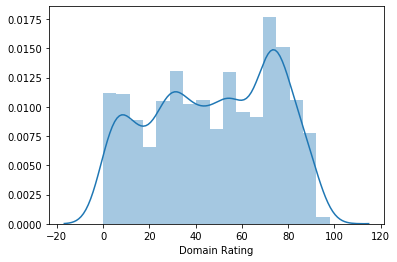

In [142]:
sns.distplot(merged_df['Domain Rating'])
plt.show()

------------------------------------------------------------------------------------------------------------------------------------

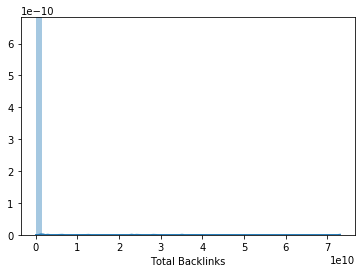

In [143]:
sns.distplot(merged_df['Total Backlinks'])
plt.show()

------------------------------------------------------------------------------------------------------------------------------------

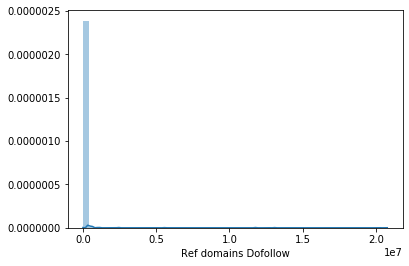

In [144]:
sns.distplot(merged_df['Ref domains Dofollow'])
plt.show()

-----------------------------------------------------------------------------------------------------------------------

In [145]:
merged_df.describe()

,result_position,#,URL Rating,Domain Rating,Ahrefs Rank,Domains,Ref domains Dofollow,Ref domains Governmental,Ref domains Educational,Ref IPs,...,Backlinks Text,Backlinks NoFollow,Backlinks Redirect,Backlinks Image,Backlinks Frame,Backlinks Form,Backlinks Governmental,Backlinks Educational,Total Keywords,Total Traffic
count,3185.000000,3185.000000,0.0,3185.000000,3.183000e+03,3.185000e+03,3.185000e+03,3185.000000,3185.000000,3.185000e+03,...,3.185000e+03,3.185000e+03,3.185000e+03,3.185000e+03,3.185000e+03,3.185000e+03,3.185000e+03,3.185000e+03,3.185000e+03,3.185000e+03
mean,19.359812,100.033281,NaN,47.659341,5.933615e+06,4.554707e+04,3.511719e+04,51.821036,244.873469,1.870347e+04,...,7.266277e+07,9.481187e+06,1.610814e+06,1.630350e+07,5.618047e+06,8.458299e+06,8.898251e+05,1.637131e+06,1.058928e+06,4.713958e+06
std,9.827527,57.476203,NaN,26.515150,1.319312e+07,7.473772e+05,5.067861e+05,566.909571,1411.911997,1.302669e+05,...,1.351366e+09,1.816405e+08,4.110244e+07,3.572016e+08,2.344300e+08,1.147844e+08,2.198937e+07,3.362902e+07,2.853832e+07,1.675874e+08
min,1.000000,1.000000,NaN,0.000000,3.000000e+00,1.000000e+00,0.000000e+00,0.000000,0.000000,2.000000e+00,...,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,11.000000,50.000000,NaN,27.000000,5.837000e+04,3.220000e+02,2.200000e+02,0.000000,0.000000,3.190000e+02,...,7.363000e+03,8.750000e+02,3.100000e+01,2.990000e+02,0.000000e+00,8.000000e+00,0.000000e+00,0.000000e+00,8.930000e+02,8.900000e+02
50%,20.000000,100.000000,NaN,50.000000,6.690560e+05,1.359000e+03,1.019000e+03,2.000000,6.000000,1.365000e+03,...,9.212400e+04,6.751000e+03,5.730000e+02,7.670000e+03,0.000000e+00,2.346000e+03,4.100000e+01,3.900000e+01,6.855000e+03,9.230000e+03
75%,28.000000,150.000000,NaN,72.000000,4.993699e+06,6.727000e+03,5.099000e+03,12.000000,55.000000,6.327000e+03,...,1.506098e+06,8.363800e+04,1.334600e+04,1.619780e+05,0.000000e+00,1.183810e+05,1.785000e+03,1.726000e+03,5.670900e+04,1.000360e+05
max,35.000000,200.000000,NaN,98.000000,1.516290e+08,3.231982e+07,2.078345e+07,20774.000000,42624.000000,5.259907e+06,...,5.324932e+10,6.709348e+09,1.669892e+09,1.436056e+10,1.223595e+10,5.518798e+09,8.722143e+08,1.149357e+09,1.584652e+09,9.397271e+09


-----------------------------------------------------------------------------------------------------------------------

From looking at the .describe() method we can see that the lowest 25% of our dataset has a DR rating of 27 or lower. As I will be running every domain for a Python selenium browser I'm happy to choose ~750 domains for prospecting.

In [150]:
business_data = merged_df[merged_df['Domain Rating'] < 27]

In [153]:
business_data.drop_duplicates(subset='Root_Domain', inplace = True)

/Users/jamesphoenix/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### We will also remove any .gov extensions

In [166]:
business_data['Root_Domain'] = business_data['Root_Domain'].apply(lambda x: np.nan if ".gov." in x else x)

1                   readingsweep.co.uk
3                        acsweep.co.uk
6       lockchimneysweepsreading.co.uk
15                                 NaN
16                 jamesthesweep.co.uk
                     ...              
3157            thebigplantnursery.com
3161                   conkersgc.co.uk
3167       haddenhamgardencentre.co.uk
3173            thompsons-plants.co.uk
3181                forest-lodge.co.uk
Name: Root_Domain, Length: 715, dtype: object

#### As we'll be querying google with every single domain we'lll extract the brand name from the Root Domain

In [169]:
query_list = list(business_data['Root_Domain'].apply(lambda x: x.split('.')[0]))

In [171]:
len(query_list)

715

In [ ]:
query_and_root_domain_data = list(zip(list(business_data['Root_Domain']),query_list ))
pickle.dump(query_and_root_domain_data, open('query_data_for_prospector.pkl', 'wb'))

We have finally reached the query level, now we can simply place every query into the GMB prospector that I made previously, you can find it here:
    
- https://github.com/jamesaphoenix/Google_My_Business_Python_Prospector

Here are the results! Happy Prospecting :) 

# The End Result After Running A GMB Prospector On Every Domain

I also decided to modify the existing script and added <strong> GMB review score, review_count and phone number to help with the prospecting aspect. </strong>

<img src='scraping_data.png' />